# From Logistic Regression in SciKit-Learn to Deep Learning with TensorFlow – A fraud detection case study – Part III

In the previous part we have build a logistic regression classifier in TensorFlow to detect credit card fraud. We will see that our logistic regression classifier is equivalent to a very simple neural network with exactly one layer with one node and sigmoid activation function. We will extend this simple network to to a deep neural network by adding more hidden layers. We will use the low level and medium level api of TensorFlow and at the end of the post we will use Keras's high level api to build a similar network just with a few lines of code.

We will use the same data and the same transformation as in the previous posts (StandardScaler).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, precision_score, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
credit_card = pd.read_csv('creditcard.csv')

In [3]:
X = credit_card.drop(columns='Class', axis=1)
y = credit_card.Class.values
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.transform(X_test)

## Deep learning / neural networks in a nutshell

A artificial neural network is collection of connected nodes. In the first layer of the network the input of our nodes are the input features. In following layers the output of previous nodes are the input to the nodes in the current layer. If we have more than 1 hidden layer we can call the network a deep neural network.


The output of the node is the composition of the dot or (scalar) product of a weights vector and the input vector and an activation function. Let be X the vector of input features and w_i the weights vector of the node i, then the output of this node is given by

$$output_i =  \phi(X^Tw_i+ b_i),$$

with an activation function $\phi$ and bias $b_i$.

If a layer consists more of one node the layer can be represented as a matrix multiplication. Such a layer is often called linear or dense layer. Typical choices for activation functions are tanh, relu, sigmoid function.



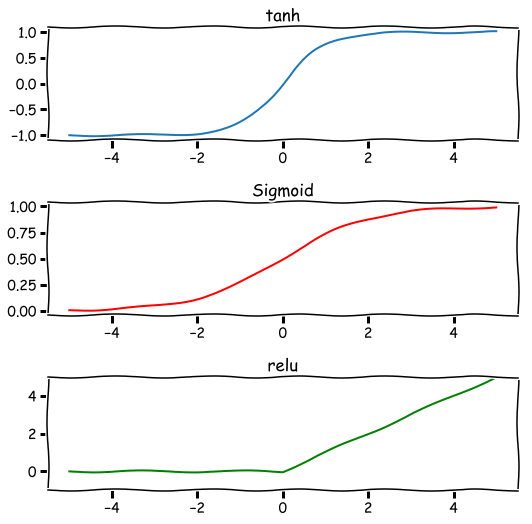

In [21]:
# Plot activation functions
def sigmoid(xs):
    return 1/(1+np.exp(-xs))
#print(plt.style.available)
#plt.style.use('seaborn-bright')
with plt.xkcd() as style:
    xs = np.linspace(-5, 5, 101)
    plt.figure(figsize=(7.5,7.5))
    plt.subplot(3,1,1)
    plt.plot(xs, np.tanh(xs))
    plt.title('tanh')
    plt.subplot(3,1,2)
    plt.plot(xs, sigmoid(xs), color='r')
    plt.title('Sigmoid')
    plt.subplot(3,1,3)
    plt.plot(xs, np.maximum(xs,0), color='g')
    plt.ylim(-1,5)
    plt.title('relu')
    plt.tight_layout()


As we can see from this formula a dense layer with one node and sigmoid function as activation is our logisitc regression model. The matrix product will be the logit and the output of the activation function will be the probability as in a logistic regression model.

Lets review the logistic regression example in a neural network setting, lets start a function which constructs the computational graph for a dense (linear) layer given a input, activation function and number of nodes.

In [5]:
def add_layer(X, n_features, n_nodes, activation=None):
    """
    Build a dense layer with n_features-dimensional input X and n_nodes (output dimensional).

    Parameters:
    
        X : 2D Input Tensor (n_samples, n_features)
        n_features = number of features in the tensor 
        n_nodes = number of nodes in layer (output dimension)
        activation = None or callable activation function 
        
    Output:
        
        Operator which returns a 2D Tensor (n_samples, n_nodes)
        
    """
    weights = tf.Variable(initial_value=tf.random_normal((n_features,n_nodes), 0, 0.1, seed=42), dtype=tf.float32)
    bias = tf.Variable(initial_value=tf.random_normal((1,n_nodes), 0, 0.1, seed=42), dtype=tf.float32)
    layer = tf.add(tf.matmul(X, weights), bias)
    if activation is None:
        return layer
    else:
        return activation(layer)

We wrapping our training and prediction functions in a class. The constructor of this class builds the computational graph in TensorFlow. The the function `create_logit` will build the computational graph to compute the logits (in the logisitc regression case: one layer with one node and the identity as activation function). We will override this function at a later point to add more layers to our network.

In [55]:
class model(object):
    def __init__(self, n_features, output_every_n_epochs=1, name='model'):
        self.input = tf.placeholder(tf.float32, shape=(None, n_features))
        self.true_values = tf.placeholder(tf.float32, shape=(None,1))
        self.training = tf.placeholder(tf.bool)
        self.logit = self.create_logit()
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.true_values, 
                                                                           logits=self.logit))
        self.predicted_probs = tf.sigmoid(self.logit)
        self.output_every_n_epochs = output_every_n_epochs
        self.name = name
        self.saver = tf.train.Saver()    


        
    def create_logit(self):
        return  add_layer(self.input, 30, 1)

    def evaluate_loss_and_probs(self, sess, X, y, training=False, output=False):
        loss, probs = sess.run([self.loss, self.predicted_probs], {self.input : X, 
                                                                   self.true_values : y.reshape(-1,1),
                                                                   self.training : training})
        probs.reshape(-1)
        y_hat = (probs > 0.5).reshape(-1)*1
        auc = roc_auc_score(y, probs)
        precision = precision_score(y, y_hat)
        recall = recall_score(y, y_hat)
        fp = np.sum((y!=y_hat) & (y==0)) 
        fpr = fp / (y==0).sum()
        if output:
            print('Loss: %.6f \t AUC %.6f \t Precision %.6f%% \t Recall %.6f%% \t FPR %.6f%%' % (loss, auc, precision*100, recall*100, fpr*100))
        return loss, probs, y_hat, auc, precision, recall
    
    
    
    def train(self, sess, X, y, n_epochs, batch_size, learning_rate):
        init = tf.global_variables_initializer()
        sess.run(init)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(self.loss)
        n_samples = X.shape[0]
        n_iter = int(np.ceil(n_samples/batch_size))
        indices = np.arange(n_samples)
        training_losses = []
        training_aucs = []
        for epoch in range(0,n_epochs):
            np.random.shuffle(indices)
            for i in range(n_iter):
                idx = indices[i*batch_size:(i+1)*batch_size]
                x_i = X[idx,:]
                y_i = y[idx].reshape(-1,1)
                sess.run(train, {self.input : x_i, 
                                 self.true_values : y_i,
                                 self.training : True})
            output=False
            if (epoch % self.output_every_n_epochs)==0:
                print(epoch, 'th Epoch')
                output=True
            loss_train_epoch, predict_train_epoch, y_hat, auc_train_epoch, _, _ = self.evaluate_loss_and_probs(sess, X, y, False, output)
            training_losses.append(loss_train_epoch)
            training_aucs.append(auc_train_epoch)
        with plt.xkcd() as style:
            plt.figure(figsize=(7,7))
            plt.subplot(2,1,1)  
            plt.title('Loss')
            plt.plot(range(n_epochs), training_losses)
            plt.xlabel('# Epoch')
            plt.subplot(2,1,2)
            plt.title('AUC')
            plt.plot(range(n_epochs), training_aucs)
            plt.xlabel('# Epoch')
            plt.tight_layout()
            plt.savefig('training_loss_auc_%s.png' % self.name, dpi=300)
        self.saver.save(sess, "./%s/model.ckpt" % self.name)
        
    def restore(self, sess):
        self.saver.restore(sess, "./%s/model.ckpt" % self.name)

Apply this function to build our Logisitc Regression model

0 th Epoch
Loss: 0.007944 	 AUC 0.980217 	 Precision 86.538462% 	 Recall 56.675063% 	 FPR 0.015388%
10 th Epoch
Loss: 0.004231 	 AUC 0.984984 	 Precision 87.591241% 	 Recall 60.453401% 	 FPR 0.014948%
Validation set:
Loss: 0.003721 	 AUC 0.977169 	 Precision 89.041096% 	 Recall 68.421053% 	 FPR 0.014068%


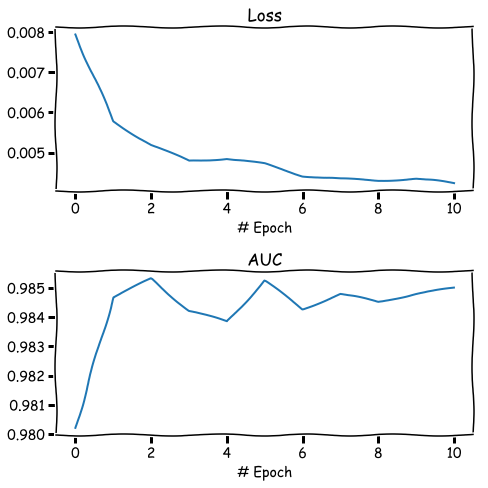

In [56]:
np.random.seed(42)
lr = model(30, 10, 'lr')
n_epochs = 11
batch_size = 100
with tf.Session() as sess:
    lr.train(sess, X_train, y_train, n_epochs, batch_size, 0.1)
    print('Validation set:')
    _, probs_lr, y_hat_lr, _, _, _ = lr.evaluate_loss_and_probs(sess, X_valid, y_valid, False, True)

### Backpropagation

In the previous parts we have seen how we can learn the weights (parameter) of our logistic regression model. So we know how to train a network with one layer but how can we train a network with more than one layer?

The concept is called Backpropagation and is basically the application of the chain rule. In the first phase (feed forward phase) the the input is feed into the network through all layers and the loss is calculated. Then in the 2nd or backward phase, the weights are updated recursevly from the last layer to the first.

At the last layer the derivate of the loss is straight forward. For the calculation of the weights in the inner or hidden layers we need the previous calculated derivates. 

With the calculated gradients we can apply again a gradient descent method to optimize our weights. 

The power of TensorFlow or other deep learning libraries as PyTorch are again the auto gradients. We dont need to worry to calculate the gradients by ourself.

A detailed deriviation of the backpropagation algorithm with an example for a quadratic loss function can be found on wikipedia.

## First deep network

Now its time for our first deep neural network. We will add 4 layers with 120, 60, 30 and 1 node.


In [57]:
class model2(model):
    
    def create_logit(self):
        layer1 = add_layer(self.input, 30, 120)
        layer2 = add_layer(layer1, 120, 60,)
        layer3 = add_layer(layer2, 60, 30)
        layer4 = add_layer(layer3, 30, 1)
        return layer4

0 th Epoch
Loss: 0.005415 	 AUC 0.979690 	 Precision 81.865285% 	 Recall 79.596977% 	 FPR 0.030776%
10 th Epoch
Loss: 0.004278 	 AUC 0.979795 	 Precision 84.824903% 	 Recall 54.911839% 	 FPR 0.017147%
Validation set
Loss: 0.003636 	 AUC 0.976299 	 Precision 89.230769% 	 Recall 61.052632% 	 FPR 0.012309%


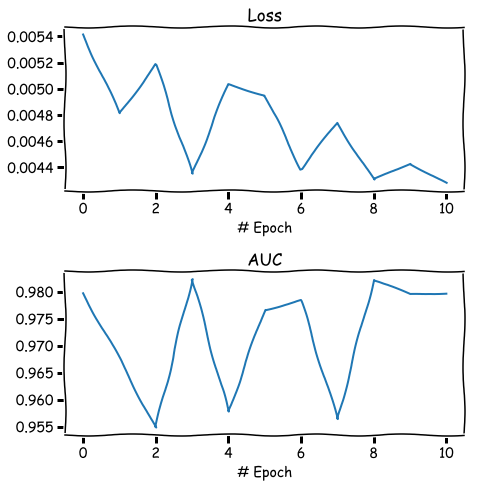

In [58]:
np.random.seed(42)
dnn1 = model2(30, 10, 'model1')
n_epochs = 11
batch_size = 100
with tf.Session() as sess:
    dnn1.train(sess, X_train, y_train, n_epochs, batch_size, 0.1)
    print('Validation set')
    _, probs_dnn1, y_hat_dnn1, _, _, _ = dnn1.evaluate_loss_and_probs(sess, X_valid, y_valid, False, True)

The performance of this network is not really good. Actually is quite bad for the complexity of the model.
The AUC on the validation set is worse than the AUC from the logistic regression.

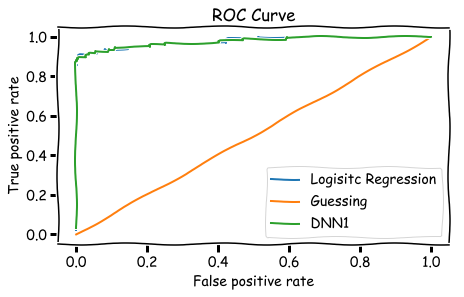

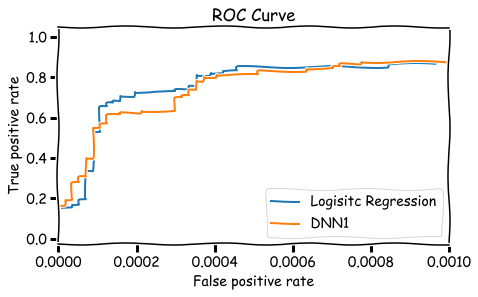

In [59]:
fpr, tpr, _ = roc_curve(y_valid, probs_lr)
fpr_1, tpr_1, _ = roc_curve(y_valid, probs_dnn1)
with plt.xkcd() as style:
    plt.figure(figsize=(7,4))
    plt.plot(fpr, tpr, [0,1], [0,1], fpr_1, tpr_1)
    plt.grid(True)
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['Logisitc Regression', 'Guessing', 'DNN1'])
    plt.savefig('roc_auc_model1.png')
    
with plt.xkcd() as style:
    plt.figure(figsize=(7,4))
    plt.plot(fpr, tpr, fpr_1, tpr_1)
    plt.xlim((0,0.001))
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['Logisitc Regression', 'DNN1'])
    plt.savefig('roc_auc_model1_detail.png')

For low FPRs the logistic regession almost always outperforms the deep neural network (DNN). A FPR of 0.1 % means that in we will have 1 false positive in 1000 transactions. If you have millions of transactions even such a low fpr can affect and your customers. In very low FPRs (less than 0.0001) the DNN have a slightly higher true positive rate (TPR).

The problem is that we use the identity as activation function. The logit is still a linear function of the input.
If we want to capture non linear dependencies we have to add a non-linear activation function. 
Let's try the RELU.

### Time for non-linearity

0 th Epoch
Loss: 0.003517 	 AUC 0.966247 	 Precision 86.857143% 	 Recall 76.574307% 	 FPR 0.020224%
10 th Epoch
Loss: 0.002087 	 AUC 0.993882 	 Precision 90.807799% 	 Recall 82.115869% 	 FPR 0.014509%
20 th Epoch
Loss: 0.001584 	 AUC 0.996813 	 Precision 90.425532% 	 Recall 85.642317% 	 FPR 0.015828%
30 th Epoch
Loss: 0.001153 	 AUC 0.998414 	 Precision 97.771588% 	 Recall 88.413098% 	 FPR 0.003517%
Validation set
Loss: 0.002456 	 AUC 0.977344 	 Precision 87.912088% 	 Recall 84.210526% 	 FPR 0.019343%


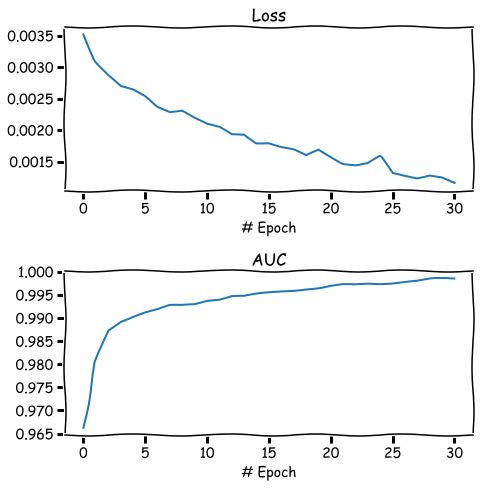

In [12]:
class model2b(model):
    
    def create_logit(self):
        layer1 = add_layer(self.input, 30, 120, tf.nn.relu)
        layer2 = add_layer(layer1, 120, 60, tf.nn.relu)
        layer3 = add_layer(layer2, 60, 30, tf.nn.relu)
        layer4 = add_layer(layer3, 30, 1)
        return layer4

np.random.seed(42)
dnn1b = model2b(30, 10, 'model1b')
n_epochs = 31
batch_size = 100
with tf.Session() as sess:
    dnn1b.train(sess, X_train, y_train, n_epochs, batch_size, 0.1)
    print('Validation set')
    _, probs_dnn1b, y_hat_dnn1b, _, _, _= dnn1b.evaluate_loss_and_probs(sess, X_valid, y_valid, False, True)

Another popular choice is `tanh`

0 th Epoch
Loss: 0.003144 	 AUC 0.980715 	 Precision 84.823848% 	 Recall 78.841310% 	 FPR 0.024621%
10 th Epoch
Loss: 0.002182 	 AUC 0.988060 	 Precision 96.407186% 	 Recall 81.108312% 	 FPR 0.005276%
20 th Epoch
Loss: 0.001906 	 AUC 0.991161 	 Precision 94.366197% 	 Recall 84.382872% 	 FPR 0.008793%
30 th Epoch
Loss: 0.001594 	 AUC 0.993034 	 Precision 99.708455% 	 Recall 86.146096% 	 FPR 0.000440%
Validation set
Loss: 0.002365 	 AUC 0.984063 	 Precision 91.666667% 	 Recall 81.052632% 	 FPR 0.012309%


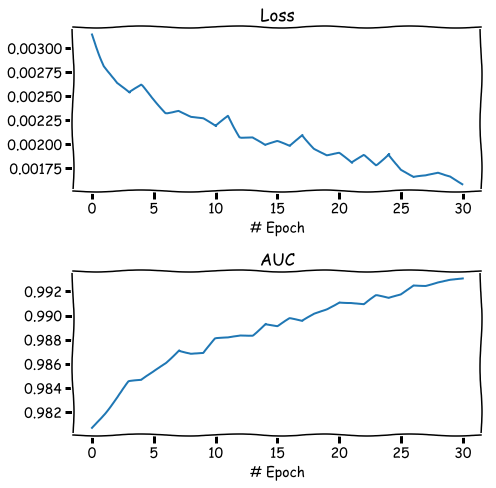

In [13]:
class model2c(model):
    
    def create_logit(self):
        layer1 = add_layer(self.input, 30, 120, tf.nn.tanh)
        layer2 = add_layer(layer1, 120, 60, tf.nn.tanh)
        layer3 = add_layer(layer2, 60, 30, tf.nn.tanh)
        layer4 = add_layer(layer3, 30, 1)
        return layer4

np.random.seed(42)
dnn1c = model2c(30, 10, 'model1c')
n_epochs = 31
batch_size = 100
with tf.Session() as sess:
    dnn1c.train(sess, X_train, y_train, n_epochs, batch_size, 0.1)
    print('Validation set')
    _, probs_dnn1c, y_hat_dnn1c, _, _, _= dnn1c.evaluate_loss_and_probs(sess, X_valid, y_valid, False, True)

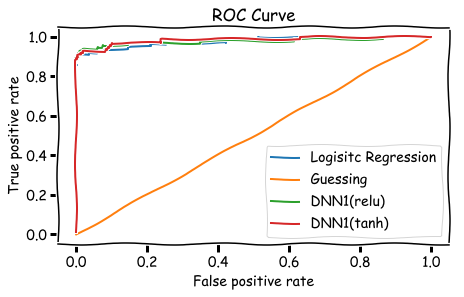

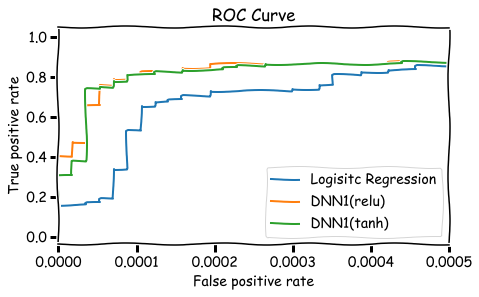

In [60]:
fpr, tpr, _ = roc_curve(y_valid, probs_lr)
fpr_1, tpr_1, _ = roc_curve(y_valid, probs_dnn1)
fpr_1b, tpr_1b, _ = roc_curve(y_valid, probs_dnn1b)
fpr_1c, tpr_1c, _ = roc_curve(y_valid, probs_dnn1c)
with plt.xkcd() as style:
    plt.figure(figsize=(7,4))
    plt.plot(fpr, tpr, [0,1], [0,1], fpr_1b, tpr_1b,fpr_1c, tpr_1c)
    plt.grid(True)
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['Logisitc Regression', 'Guessing', 'DNN1(relu)', 'DNN1(tanh)'])
    plt.savefig('roc_auc_model1c.png')

    
with plt.xkcd() as style:
    plt.figure(figsize=(7,4))
    plt.plot(fpr, tpr, fpr_1b, tpr_1b,fpr_1c, tpr_1c)
    plt.xlim((0,0.0005))
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['Logisitc Regression', 'DNN1(relu)', 'DNN1(tanh)'])
    plt.savefig('roc_auc_model1c_detail.png')



We see that both non linear models outperforms the logistic regression. For low FPRs the TPR is signifanct higher.
Assume we would accept a FPR of 0.01 %, then the Recall of our DNN is around 80% vs 50% for the logistic regression.
We can detect much more fraudulent transactions with the same rate of false alarms.

### Using TensorFlow layers

Instead of building the computational graph our self (weights, bias tensor, etc) we can use TensorFlow Layers. The function `tf.layers.dense` build a linear or dense layer. We can specify the number of nodes, the input and the actication function (similar to our own function).

In the next layer we use the TensorFlow function and add on more layer.

In [15]:
class model3(model):
    
    def create_logit(self):
        layer1 = tf.layers.dense(self.input, 240, activation=tf.nn.tanh)
        layer2 = tf.layers.dense(layer1, 120, activation=tf.nn.tanh)
        layer3 = tf.layers.dense(layer2, 60, activation=tf.nn.tanh)
        layer4 = tf.layers.dense(layer3, 30, activation=tf.nn.tanh)
        layer5 = tf.layers.dense(layer4, 1)
        return layer5

0 th Epoch
Loss: 0.003000 	 AUC 0.986239 	 Precision 82.428941% 	 Recall 80.352645% 	 FPR 0.029897%
10 th Epoch
Loss: 0.002036 	 AUC 0.992393 	 Precision 95.626822% 	 Recall 82.619647% 	 FPR 0.006595%
20 th Epoch
Loss: 0.001598 	 AUC 0.995232 	 Precision 93.989071% 	 Recall 86.649874% 	 FPR 0.009673%
30 th Epoch
Loss: 0.001273 	 AUC 0.996695 	 Precision 99.137931% 	 Recall 86.901763% 	 FPR 0.001319%
Validation set
Loss: 0.002425 	 AUC 0.980571 	 Precision 91.764706% 	 Recall 82.105263% 	 FPR 0.012309%


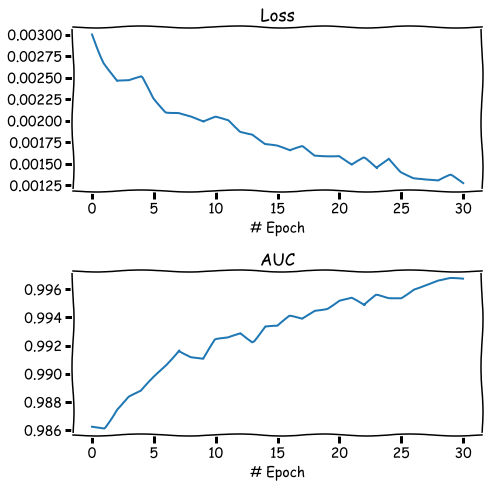

In [16]:
np.random.seed(42)
dnn2 = model3(30, 10, 'model2')
n_epochs = 31
batch_size = 100
with tf.Session() as sess:
    dnn2.train(sess, X_train, y_train, n_epochs, batch_size, 0.1)
    print('Validation set')
    _, probs_dnn2, y_hat_dnn2, _, _, _= dnn2.evaluate_loss_and_probs(sess, X_valid, y_valid, False, True)

The model didn't improve to the previous one. Maybe we are now overfitting. One way to prevent overfitting in DNN are dropouts. Dropouts deactive a proportion of nodes during training randomnly. So we prevent our neural network to memorize the training data. Lets add dropout layers to the previous model.

Lets use a dropout rate of 20%.

In [34]:
class model4(model):
    
    def create_logit(self):
        layer1 = tf.layers.dense(self.input, 120, activation=tf.nn.tanh)
        layer1 = tf.layers.dropout(layer1, 0.2, training=self.training)
        layer2 = tf.layers.dense(layer1, 60, activation=tf.nn.tanh)
        layer2 = tf.layers.dropout(layer2, 0.2, training=self.training)
        layer3 = tf.layers.dense(layer2, 30, activation=tf.nn.tanh)
        layer3 = tf.layers.dropout(layer3, 0.2, training=self.training)
        layer4 = tf.layers.dense(layer3, 1)
        return layer4

0 th Epoch
Loss: 0.003292 	 AUC 0.980809 	 Precision 83.244681% 	 Recall 78.841310% 	 FPR 0.027699%
10 th Epoch
Loss: 0.002579 	 AUC 0.988964 	 Precision 87.887324% 	 Recall 78.589421% 	 FPR 0.018905%
20 th Epoch
Loss: 0.002339 	 AUC 0.991154 	 Precision 92.375367% 	 Recall 79.345088% 	 FPR 0.011431%
30 th Epoch
Loss: 0.002049 	 AUC 0.992268 	 Precision 95.238095% 	 Recall 80.604534% 	 FPR 0.007035%
Validation set
Loss: 0.002183 	 AUC 0.984921 	 Precision 89.887640% 	 Recall 84.210526% 	 FPR 0.015826%


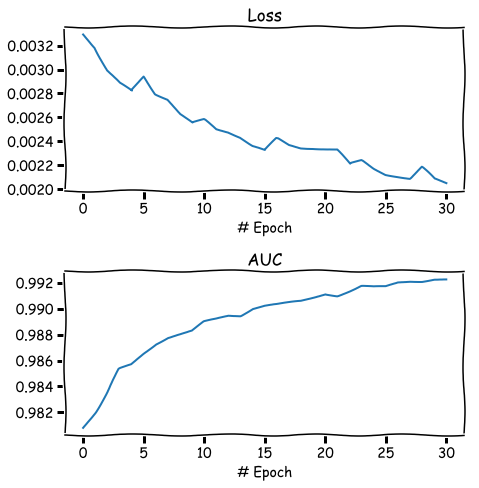

In [40]:
np.random.seed(42)
dnn3 = model4(30, 10, 'model3')
n_epochs = 31
batch_size = 100
with tf.Session() as sess:
    dnn3.train(sess, X_train, y_train, n_epochs, batch_size, 0.1)
    print('Validation set')
    _, probs_dnn3, y_hat_dnn3, _, _, _= dnn3.evaluate_loss_and_probs(sess, X_valid, y_valid, False, True)

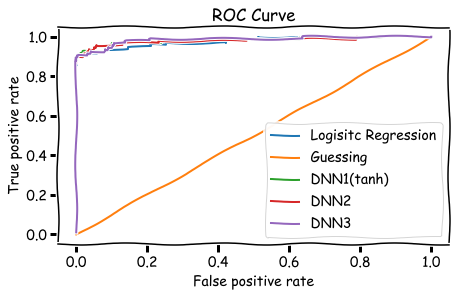

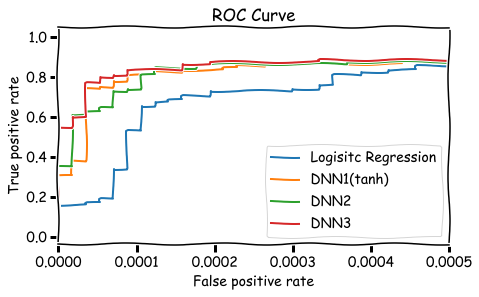

In [41]:
fpr, tpr, _ = roc_curve(y_valid, probs_lr)
fpr_1c, tpr_1c, _ = roc_curve(y_valid, probs_dnn1c)
fpr_2, tpr_2, _ = roc_curve(y_valid, probs_dnn2)
fpr_3, tpr_3, _ = roc_curve(y_valid, probs_dnn3)
with plt.xkcd() as style:
    plt.figure(figsize=(7,4))
    plt.plot(fpr, tpr, [0,1], [0,1], fpr_1c, tpr_1c,fpr_2, tpr_2,fpr_3, tpr_3)
    plt.grid(True)
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['Logisitc Regression', 'Guessing', 'DNN1(tanh)', 'DNN2', 'DNN3'])
    plt.savefig('auc_models_2.png', dpi=300)
    
with plt.xkcd() as style:
    plt.figure(figsize=(7,4))
    plt.plot(fpr, tpr, fpr_1c, tpr_1c,fpr_2, tpr_2,fpr_3, tpr_3)
    plt.xlim((0,0.0005))
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['Logisitc Regression', 'DNN1(tanh)', 'DNN2', 'DNN3'])
    plt.savefig('auc_models_2_detail.png', dpi=300)

We see that all our deep learning model outperform the LR model on the validation set. The difference in AUC doesn't seems very big, but especially for very low FPR the recall is much higher.

Lets go for model 3 (4 layers with dropout) and let see the AUC Score of the model on the test data.

In [43]:
with tf.Session() as sess:
    dnn3.restore(sess)
    print('Test set')
    _, probs_dnn3_test, y_hat_dnn3_test, _, _, _= dnn3.evaluate_loss_and_probs(sess, X_test, y_test, False, True)

INFO:tensorflow:Restoring parameters from ./model3/model.ckpt
Test set
Loss: 0.001825 	 AUC 0.991294 	 Precision 97.619048% 	 Recall 83.673469% 	 FPR 0.003517%


This model performs very well on our test set. We have a high Recall with a very low FPR at a threshold of 50%.

### Keras

The library Keras offers a very convinient API to TensorFlow (but it also supports other deep learning backends). 

We can build the same model in just 6 lines of code. For many standard problems there are predefined loss functions, but we can also write our own loss functions in Keras.

In [44]:
model = keras.Sequential()
model.add(keras.layers.Dense(120, input_shape=(30,), activation='tanh'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(60, activation='tanh'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(30, activation='tanh'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


For the model training we only need one line of code.

In [46]:
model.fit(X_train, y_train, epochs=31, batch_size=100)

Epoch 1/31
227845/227845 [==============================] - 4s 18us/step - loss: 0.0034
Epoch 2/31
227845/227845 [==============================] - 4s 18us/step - loss: 0.0032
Epoch 3/31
227845/227845 [==============================] - 4s 19us/step - loss: 0.0031
Epoch 4/31
227845/227845 [==============================] - 4s 18us/step - loss: 0.0031
Epoch 5/31
227845/227845 [==============================] - 4s 18us/step - loss: 0.0030
Epoch 6/31
227845/227845 [==============================] - 4s 19us/step - loss: 0.0028
Epoch 7/31
227845/227845 [==============================] - 4s 18us/step - loss: 0.0027
Epoch 8/31
227845/227845 [==============================] - 4s 19us/step - loss: 0.0028
Epoch 9/31
227845/227845 [==============================] - 4s 18us/step - loss: 0.0026
Epoch 10/31
227845/227845 [==============================] - 4s 19us/step - loss: 0.0025
Epoch 11/31
227845/227845 [==============================] - 4s 19us/step - loss: 0.0024
Epoch 12/31
227845/227845 [===

The prediction is also a one liner

In [51]:
probs_keras = model.predict(X_test)

In [53]:
# We reach a similar AUC

In [52]:
roc_auc_score(y_test, probs_keras)

0.9986178982003606


In this part we saw how to build and train a deep neural network with TensorFlow using the low level and mid level API and as an outlook we saw how easy the model development is in a high level API like Keras.

For this fraud detection problem a very simple deep network can outperform a classical machine learning algorithm like logistic regression if we looking into the low false positive rate (FPR) regions. If we can accept higher false positive rates all models perform similar.

To decide for a final model, one need to specify the costs of a FP (a genuine transaction which we maybe block or at least investigate) and FN (a fraudulent transaction which we miss), so we can balance the trade-off between Recall (detection power) and FPR.

Our fraud detection problem is as we know a imbalance class problem. We can maybe improve the quality of the logistic regression with use of over-/undersampling of the majority class. Or we can use try other 'classical' machine learning methods like random forests or boosting trees, which often outperform a logisitc regression. 

Another interesting unsupervised deep learning method to detect anomalies in transactions are auto-encoders.

I think I will cover these topics in later posts. So stay tuned.

As usual you can find the notebook on my github, so please download the notebook and play with the model parameter, e.g one could change numbers of epochs we train, apply adaptive learning rates or add more layer or change the numbers of nodes in each layer and play with dropouts to find better models and please share your ideas and results.

So long...


